In [2]:
## This Cell is related to date preprocessing and is completely copied from original kipf's github code!

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as sp
import torch,torch.nn,torch.sparse,torch.nn.functional,torch.distributions
from sklearn.metrics import roc_auc_score,average_precision_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
np.set_printoptions(threshold=np.inf)


from google.colab import drive
drive.mount('/content/drive')


W_gene      =  pd.read_table( "/content/drive/My Drive/Data Fusion/GBM_Adjacency_matrices/gene.txt", delim_whitespace=True).to_numpy()
W_methy     =  pd.read_table( "/content/drive/My Drive/Data Fusion/GBM_Adjacency_matrices/methy.txt", delim_whitespace=True).to_numpy()
W_mirna     =  pd.read_table( "/content/drive/My Drive/Data Fusion/GBM_Adjacency_matrices/mirna.txt", delim_whitespace=True).to_numpy()
W_fused     =  pd.read_table( "/content/drive/My Drive/Data Fusion/GBM_Adjacency_matrices/W_fused.txt", delim_whitespace=True).to_numpy()

gene      =  pd.read_table( "/content/drive/My Drive/Data Fusion/GBM/GLIO_Gene_Expression.txt", delim_whitespace=True).to_numpy().transpose()
methy     =  pd.read_table( "/content/drive/My Drive/Data Fusion/GBM/GLIO_Methy_Expression.txt", delim_whitespace=True).to_numpy().transpose()
mirna     =  pd.read_table( "/content/drive/My Drive/Data Fusion/GBM/GLIO_Mirna_Expression.txt", delim_whitespace=True).to_numpy().transpose()
truelabel =  pd.read_table( "/content/drive/My Drive/Data Fusion/GBM/GLIO_Survival.txt", delim_whitespace=True).to_numpy()



print(gene.shape)
print(methy.shape)
print(mirna.shape)

def get_nomralized_laplacian(a):
    no = a.shape[0]
    #a[range(no),range(no)]=1
    b = np.diag(np.power(1.0 / a.sum(axis=1), 0.5))
    return (b @ a @ b)










Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: FutureWarning: read_table is deprecated, use read_csv inste

(215, 12042)
(215, 1305)
(215, 534)


In [0]:
#Model definition Cell

cluster_num = 3
emb_dim = 100



class Model(torch.nn.Module):

    def __init__(self,optimizer_type,A_tilda_gene,A_tilda_methy,A_tilda_mirna,**kwargs):
        super(Model, self).__init__(**kwargs)
        
        
        

        self.L_layer = torch.nn.Linear(cluster_num,215,bias=False)


        ###########################

        
            

        self.W0 = torch.nn.Linear(215,emb_dim)
        self.W1 = torch.nn.Linear(emb_dim,215)
       
        self.attn_gene = torch.nn.Linear(215,1)
        self.attn_methy = torch.nn.Linear(215,1)
        self.attn_mirna = torch.nn.Linear(215,1)
        
        param_list = []
        param_list += list(self.W0.parameters())
        param_list += list(self.W1.parameters())
        param_list += list(self.attn_gene.parameters())
        param_list += list(self.attn_methy.parameters())
        param_list += list(self.attn_mirna.parameters())
        param_list += list(self.L_layer.parameters())
        
        self.A_tilda_gene = A_tilda_gene
        self.A_tilda_methy = A_tilda_methy
        self.A_tilda_mirna = A_tilda_mirna

        
        if optimizer_type == 'adam':
          self.optimizer = torch.optim.Adam(param_list,lr=0.01)
        elif optimizer_type=='lbfgs':
          self.optimizer = torch.optim.LBFGS(param_list,lr=0.01,max_iter=20)
        self.recon = None
        
        self.normal_dist = torch.distributions.MultivariateNormal(loc=torch.zeros(emb_dim),scale_tril=torch.eye(emb_dim))

        
        
        
    


        
    def forward(self,x) : 
        
        self.g_prim_gene =  self.attn_gene(self.A_tilda_gene).view(-1,1)
        self.g_prim_methy =  self.attn_methy(self.A_tilda_methy).view(-1,1)
        self.g_prim_mirna =  self.attn_mirna(self.A_tilda_mirna).view(-1,1)
        self.g_prim = torch.cat([self.g_prim_gene,self.g_prim_methy,self.g_prim_mirna],1)
        self.g = torch.nn.functional.softmax(self.g_prim,dim=1)
        self.g_gene = self.g[:,0].view(-1)
        self.g_methy = self.g[:,1].view(-1)
        self.g_mirna = self.g[:,2].view(-1)

        self.A_tilda_hat = torch.diag(self.g_gene) @ self.A_tilda_gene @ torch.diag(self.g_gene)  +    torch.diag(self.g_methy) @ self.A_tilda_methy @ torch.diag(self.g_methy)   +    torch.diag(self.g_mirna) @ self.A_tilda_mirna @ torch.diag(self.g_mirna)
        #self.A_tilda_hat = torch.diag(self.g_gene) @ self.A_tilda_gene   +    torch.diag(self.g_methy) @ self.A_tilda_methy    +    torch.diag(self.g_mirna) @ self.A_tilda_mirna 

        #self.A_tilda_hat = torch.Tensor(np.identity(215))
        #self.A_tilda_hat = self.A_tilda_gene
        
        
        #self.layer_2 = torch.nn.functional.sigmoid(self.A_tilda_hat @ self.W1(self.layer_1))
        #self.layer_2 =  self.A_tilda_hat @ self.W1(self.layer_1)
        #self.layer_1 = torch.nn.functional.relu(self.A_tilda_hat @ self.W0(x))+ 0 * self.normal_dist.sample((x.shape[0],))
        self.layer_1 = torch.nn.functional.relu(self.A_tilda_hat @ self.W0(x))

        self.layer_2 = torch.nn.functional.softmax(self.A_tilda_hat @ self.W1(self.layer_1),1)
        

        self.x_prim = self.layer_2
        self.embedding = self.layer_1
        
        #self.recon_loss = (torch.abs(self.x_prim-x)).sum(1).mean(0)
        #self.recon_loss = ((self.x_prim-x)**2).sum(1).mean(0)
        self.recon_loss = torch.nn.functional.cross_entropy(self.x_prim, target=torch.nonzero(x)[:,1],reduction='mean')
        self.fair_attention_loss = self.g_gene.mean()*torch.log(self.g_gene.mean()) + self.g_methy.mean()*torch.log(self.g_methy.mean()) + self.g_mirna.mean()*torch.log(self.g_mirna.mean()) 

        self.L = self.L_layer(torch.Tensor(np.identity(cluster_num)))
        
        self.clustering_loss = torch.trace( self.L @ self.A_tilda_hat @ self.L.transpose(0,1) )
        
        self.ortho_L_loss = self.L @ self.L.transpose(0,1) - torch.Tensor(np.identity(cluster_num)) 
        #self.ortho_L_loss = (self.ortho_L_loss**2).mean()
        self.ortho_L_loss = (torch.abs(self.ortho_L_loss)).mean()

        #pos_weight = 215
        #self.layer_12 = self.A_tilda_hat @ self.W1(self.layer_1)
        #self.recon_loss = pos_weight * torch.nn.functional.logsigmoid(self.layer_12)*x +  torch.nn.functional.logsigmoid(-self.layer_12)*(1-x)
        #self.recon_loss = -1*self.recon_loss.sum(1).mean(0)

        
        #self.loss = self.recon_loss + 0.001 * self.fair_attention_loss + 0.1 * self.ortho_L_loss + 0.1* self.clustering_loss + 0.01*(self.layer_1**2).mean(1).mean(0)
        #self.loss = self.recon_loss +  0*(self.layer_1**2).mean(1).mean(0)
        self.loss = self.recon_loss 
        #self.loss = self.recon_loss +  0.001*(self.layer_1**2).mean(1).mean(0)
        #self.loss = self.L.data.sum()
        #self.l1_regularization =  (torch.norm(list(self.W0.parameters())[0],1))+(torch.norm(list(self.W1.parameters())[0],1))
        #self.KL_loss = (self.embedding**2).mean(1).mean(0)
        #self.loss = self.recon_loss+self.KL_loss/50+self.l1_regularization/1000000
       
        
        
        
        
        
        return self.loss.item(),self.recon_loss.item(),self.fair_attention_loss.item(),self.ortho_L_loss.item(),self.clustering_loss
        
    def backprop(self) :
        
        self.optimizer.zero_grad()
        self.loss.backward()
        self.optimizer.step()

        
    def backprop2(self,x):
      def closure():
        self.optimizer.zero_grad()
        self.forward(x)
        self.loss.backward()
        return self.loss
      self.optimizer.step(closure)    
    
      


In [37]:
#Training Cell  LBFGS
#optimzier_type = 'lbfgs'
optimzier_type = 'adam'

my_model = Model(optimzier_type,torch.Tensor(get_nomralized_laplacian(W_gene)),torch.Tensor(get_nomralized_laplacian(W_methy)),torch.Tensor(get_nomralized_laplacian(W_mirna)))

train_features_tensor = torch.Tensor(np.identity(215))

for epoch_counter in range(10000):

  # permutation = np.arange(215)
  # np.random.shuffle(permutation)
  # permuted_i = np.zeros((215,215))
  # for i in range(215):
  #   permuted_i[i,permutation[i]]=1
  # permuted_i_tensor = torch.Tensor(permuted_i)
  # train_features_tensor = permuted_i_tensor
  
  
  if optimzier_type=='lbfgs':
    my_model.backprop2(train_features_tensor)
  elif optimzier_type=='adam':
    my_model.forward(train_features_tensor)
    my_model.backprop()

  if epoch_counter % 100 ==0:
      loss,recon_loss,fair_attention_loss,ortho_L_loss,clustering_loss = my_model.forward(train_features_tensor)
      print("Epoch:", '%04d' % (epoch_counter + 1), "train_loss=", "{:.5f}".format(loss), "recon_loss=", "{:.5f}".format(recon_loss), "fair_attention_loss=", "{:.5f}".format(fair_attention_loss), "ortho_L_loss=", "{:.5f}".format(ortho_L_loss), "clustering_loss=", "{:.5f}".format(clustering_loss))
      # plt.scatter(x=range(215), y=torch.Tensor(my_model.g_gene).detach().numpy(), s=1, c= 'red', alpha=0.5)
      # plt.scatter(x=range(215), y=torch.Tensor(my_model.g_methy).detach().numpy(), s=1, c= 'green', alpha=0.5)
      # plt.scatter(x=range(215), y=torch.Tensor(my_model.g_mirna).detach().numpy(), s=1, c= 'blue', alpha=0.5)
      # plt.show()
      
      # A_tilda = torch.Tensor(my_model.A_tilda_hat).detach().numpy()
      # A_tilda_intermediate = ro.r.matrix(A_tilda, nrow=A_tilda.shape[0], ncol=A_tilda.shape[1])
      # ro.r.assign("A_tilda", A_tilda_intermediate)
      # %R group_sc_A_tilda <- NL_spectralClustering(A_tilda, K=3, type = 3) 
      # %R print(table(group_sc_A_tilda))
      # %R print(get_cox_pvalue(group_sc_A_tilda)[[9]][3])
      # print("@@@@@@")
      # emb = torch.Tensor(my_model.layer_1).detach().numpy()
      # emb_intermediate = ro.r.matrix(emb, nrow=emb.shape[0], ncol=emb.shape[1])
      # ro.r.assign("emb", emb_intermediate)
      # %R group_sc_emb <- kmeans(emb, 3, nstart = 25)$cluster 
      # %R print(table(group_sc_emb))
      # %R print(get_cox_pvalue(group_sc_emb)[[9]][3])
      print("@@@@@@@@@@@@")
      # %R Dist_emb = dist2(as.matrix(emb),as.matrix(emb))
      # %R W_emb = affinityMatrix(Dist_emb, K=20, alpha=1)
      # %R group_sc_W_emb = spectralClustering(W_emb,3, type = 3)
      # %R print(table(group_sc_W_emb))
      # %R print(get_cox_pvalue(group_sc_W_emb)[[9]][3])
      print("###############################################")


print('\n',"#########################################################",'\n')






Epoch: 0001 train_loss= 5.37063 recon_loss= 5.37063 fair_attention_loss= -1.09746 ortho_L_loss= 8.93363 clustering_loss= 0.45704
@@@@@@@@@@@@
###############################################
Epoch: 0101 train_loss= 5.36896 recon_loss= 5.36896 fair_attention_loss= -0.78020 ortho_L_loss= 8.93363 clustering_loss= 0.75550
@@@@@@@@@@@@
###############################################
Epoch: 0201 train_loss= 5.36269 recon_loss= 5.36269 fair_attention_loss= -0.09747 ortho_L_loss= 8.93363 clustering_loss= 1.30059
@@@@@@@@@@@@
###############################################
Epoch: 0301 train_loss= 5.35408 recon_loss= 5.35408 fair_attention_loss= -0.01388 ortho_L_loss= 8.93363 clustering_loss= 1.34226
@@@@@@@@@@@@
###############################################
Epoch: 0401 train_loss= 5.34803 recon_loss= 5.34803 fair_attention_loss= -0.00594 ortho_L_loss= 8.93363 clustering_loss= 1.34519
@@@@@@@@@@@@
###############################################
Epoch: 0501 train_loss= 5.34049 recon_loss= 5.3404

KeyboardInterrupt: ignored

In [33]:
#my_model.forward(train_features_tensor)
#print((torch.abs(my_model.x_prim-train_features_tensor)).sum(1).mean(0))
print(my_model.layer_1.shape)
print(my_model.layer_2.shape)
print(my_model.layer_2[0:7,0:7])
print(torch.abs(my_model.x_prim-train_features_tensor).sum(1).mean(0))

torch.Size([215, 40])
torch.Size([215, 215])
tensor([[4.3401e-10, 7.0350e-02, 8.2793e-12, 2.3824e-10, 3.2286e-42, 4.9634e-28,
         2.0804e-03],
        [1.5267e-11, 8.3015e-01, 1.8404e-13, 3.6454e-12, 0.0000e+00, 6.7003e-31,
         4.6766e-03],
        [2.2207e-09, 3.9860e-02, 7.3038e-11, 2.8195e-09, 1.4471e-41, 3.4210e-27,
         8.7769e-02],
        [7.2976e-10, 2.2486e-03, 2.4113e-11, 1.7688e-09, 4.7644e-44, 9.5379e-29,
         3.5108e-02],
        [6.6982e-12, 1.1006e-01, 9.3422e-14, 6.6895e-12, 0.0000e+00, 2.0664e-34,
         3.6299e-01],
        [9.6833e-14, 8.7376e-04, 3.2333e-15, 1.9665e-13, 0.0000e+00, 2.4576e-35,
         6.5359e-01],
        [1.4809e-10, 1.2911e-02, 5.7905e-12, 2.3731e-10, 1.8217e-44, 3.5650e-29,
         6.0781e-01]], grad_fn=<SliceBackward>)
tensor(1.8395, grad_fn=<MeanBackward2>)


In [0]:
my_model.forward(train_features_tensor)
#print(my_model.x_prim)

permutation = np.arange(215)
np.random.shuffle(permutation)
permuted_i = np.zeros((215,215))
for i in range(215):
  permuted_i[i,permutation[i]]=1
permuted_i_tensor = torch.Tensor(permuted_i)
my_model.forward(permuted_i_tensor)
permuted_i_response_tensor = my_model.layer_2

compare_tensor = (np.c_[torch.nonzero(permuted_i_tensor)[:,1].numpy(),permuted_i_response_tensor.argmax(1).numpy()])
print(np.abs(compare_tensor[:,0]-compare_tensor[:,1]).sum())
#print()

12580


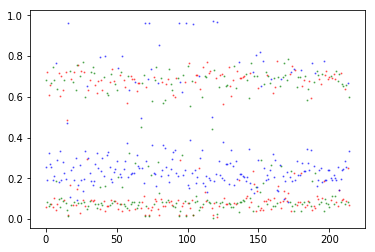

In [0]:
#print(my_model.g_gene)
#print(my_model.g_mirna)
plt.scatter(x=range(215), y=my_model.g_gene.detach().numpy(), s=1, c= 'red', alpha=0.5)
plt.scatter(x=range(215), y=my_model.g_methy.detach().numpy(), s=1, c= 'green', alpha=0.5)
plt.scatter(x=range(215), y=my_model.g_mirna.detach().numpy(), s=1, c= 'blue', alpha=0.5)

#print(my_model.A_tilda_gene)
#print(W_gene[range(215),range(215)])
#print(W_methy[range(215),range(215)])
#print(W_mirna[range(215),range(215)])

#print(my_model.A_tilda_gene)
#ordx = np.argsort(my_model.g_gene.detach().numpy())
#ordxx = ordx[0:150]
#ordxxx = ordx[150:215]
#plt.scatter(x=range(215), y=my_model.g_gene.detach().numpy(), s=1, c= 0.1*np.ones(215), alpha=0.5)
#plt.scatter(x=range(215), y=my_model.g_mirna.detach().numpy()[ordx], s=1, c= 0.1*np.ones(215), alpha=0.5)
#print(np.c_[my_model.g_gene.detach().numpy()[ordx],np.array(range(215))])
#print(truelabel[:,1][ordxx].mean())
#print(truelabel[:,1][ordxxx].mean())
#print()
#plt.scatter(x=range(215), y=my_model.g_gene.detach().numpy(), s=1, c= 0.1*np.ones(215), alpha=0.5)
#plt.scatter(x=range(215), y=my_model.g_methy.detach().numpy(), s=1, c= 0.4*np.ones(215), alpha=0.5)
#plt.scatter(x=range(215), y=my_model.g_mirna.detach().numpy(), s=1, c= 0.9*np.ones(215), alpha=0.5)
plt.show()


In [0]:

#np.savetxt("/content/drive/My Drive/Data Fusion/results/W_v51.txt",my_model.A_tilda_hat.detach().numpy(),delimiter='\t')
#np.savetxt("/content/drive/My Drive/Data Fusion/results/emb_v50.txt",my_model.embedding.detach().numpy(),delimiter='\t')
print(my_model.A_tilda_hat.detach().numpy())

[[5.17092347e-01 4.21754776e-05 3.66243039e-05 3.32198069e-05
  1.18710559e-05 2.59020344e-05 1.72310538e-05 2.09943209e-05
  1.93038941e-05 1.36202661e-05 1.48869676e-05 2.68434724e-05
  2.96204871e-05 2.43591712e-05 1.40676657e-05 2.96024609e-05
  3.13587807e-05 2.95643913e-05 1.45551776e-05 2.11300576e-05
  3.35273689e-05 8.64714639e-06 1.16554584e-05 2.59827793e-05
  1.90844221e-05 2.70754208e-05 2.03061463e-05 1.29078962e-05
  2.35802036e-05 2.84578819e-05 2.16074368e-05 3.14238969e-05
  9.41864255e-06 1.82629919e-05 1.70616077e-05 1.91883646e-05
  1.73939734e-05 1.12368307e-05 2.04921616e-05 1.20235018e-05
  1.22751171e-05 2.28312310e-05 2.32993116e-05 1.64841931e-05
  2.64284154e-05 1.36387625e-05 1.15690018e-05 1.65572892e-05
  1.65646798e-05 3.20116778e-05 1.64467783e-05 2.52868631e-05
  1.15149196e-05 2.48658325e-05 1.03424909e-05 7.43905093e-06
  1.00238767e-05 1.04215578e-05 7.85071461e-06 2.10019916e-05
  1.51704617e-05 2.20663842e-05 7.36660377e-06 1.90863175e-05
  1.0927

In [0]:
my_model.forward(train_features_tensor)
emb = my_model.embedding.detach().numpy()
np.savetxt("/content/drive/My Drive/Data Fusion/results/emb_v21.txt",emb,delimiter='\t')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [0]:
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
emb = np.loadtxt("/content/drive/My Drive/Data Fusion/results/emb_v11.txt",delimiter='\t')

[1, 1, 1, 1, 1]

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


0.046443432569503784 0.012687854766845703 0.108401984375


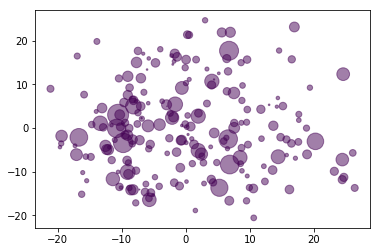

In [0]:
####PCA on embedding
my_model.forward(train_features_tensor)
emb = my_model.embedding.detach().numpy()
circle_areas = (truelabel[:,1].astype(float)/8)
X_embedded = PCA(n_components=2).fit_transform(emb)
plt.scatter(x=X_embedded[:,0], y=X_embedded[:,1], s=circle_areas, c= 1*np.ones(215), alpha=0.5)
plt.show()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1374: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


0.0467371791601181 0.012687854766845703 0.108401984375


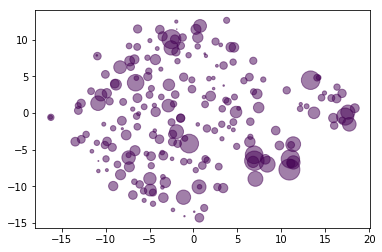

In [0]:
### TSNE on embedding
my_model.forward(train_features_tensor)
emb = my_model.embedding.detach().numpy()
circle_areas = (truelabel[:,1].astype(float)/8)
X_embedded = TSNE(n_components=2).fit_transform(emb)
plt.scatter(x=X_embedded[:,0], y=X_embedded[:,1], s=circle_areas, c= 1*np.ones(215), alpha=0.5)
plt.show()

In [0]:
from sklearn.cluster import KMeans
X = emb
n_clusters=3
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)

for i in range(n_clusters):
    indx = np.argwhere(kmeans.labels_==i).reshape(-1)
    print(truelabel[indx][:,1].mean())



626.8765432098766
536.3030303030303
573.3168316831683


In [0]:
%load_ext rpy2.ipython

In [0]:
%%R

	

#install.packages("SNFtool")
#install.packages("data.table")
#install.packages("dplyr")
#install.packages("pheatmap")
#install.packages("mltools")
#install.packages("survival")
# install.packages("factoextra")
#install.packages("gplots")
#library(gplots)
#install.packages("ggplot2")
#install.packages("survminer")


library(SNFtool)
library(data.table)
library(dplyr)
library(pheatmap)
library(mltools)
library(survival)
#library(factoextra)
library(ggplot2)
library(survminer)








In [0]:
%%R
NL_spectralClustering <- function (NL, K, type = 3) 
{
	eig <- eigen(NL)
	res <- sort(abs(eig$values), index.return = TRUE)
	U <- eig$vectors[, res$ix[1:K]]
	normalize <- function(x) x/sqrt(sum(x^2))
	if (type == 3) {
		U <- t(apply(U, 1, normalize))
	}     
	
	eigDiscrete <- SNFtool:::.discretisation(U)
	eigDiscrete <- eigDiscrete$discrete
	labels <- apply(eigDiscrete, 1, which.max)
	return(labels)
}

get_cox_pvalue<-function(group){
  one_hot_group <- matrix(0, 215, max(group))
  for (i in 1:215){
    one_hot_group[i,group[i]]<-1
  }
  tt<-coxph(Surv( survival,censor ) ~ one_hot_group)
  return(summary(tt))
}

get_cox_pvalue2<-function(group){
  tt<-coxph(Surv( survival,censor ) ~ group)
  return(summary(tt))
}


In [23]:
emb = my_model.A_tilda_hat.detach().numpy()

import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()


emb_intermediate = ro.r.matrix(emb, nrow=emb.shape[0], ncol=emb.shape[1])
ro.r.assign("W_emb", emb_intermediate)

survival_intermediate = ro.r.matrix(truelabel[:,1], nrow=215, ncol=1)
ro.r.assign("survival", survival_intermediate)

censor_intermediate = ro.r.matrix(truelabel[:,2], nrow=215, ncol=1)
ro.r.assign("censor", censor_intermediate)

%R survival <- as.numeric(survival)
%R censor <- as.numeric(censor)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [0]:
%%R
#group_sc <- NL_spectralClustering(W_emb, K=3, type = 3) 
#group_sc
#typeof(survival)
class(survival)


#get_cox_pvalue(group_sc)[[9]][3]

#censor

[1] "numeric"
